In [8]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 


from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
%matplotlib inline
#plt.style.use(['dark_background'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


dx: 0.9762202753441801 cm
nx 800


Text(0, 0.5, 'z (m)')

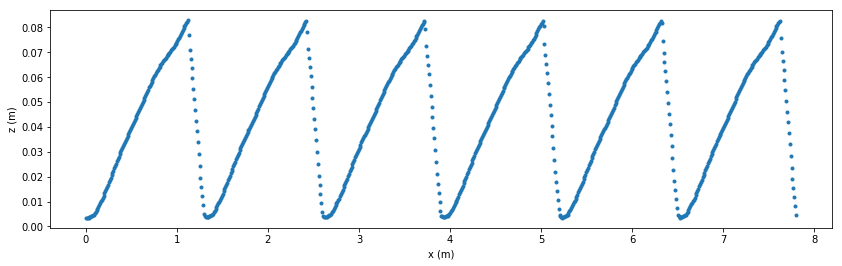

In [9]:
filepath = 'dune_profile_dune5_repeated.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 800)

dx = x0[1] - x0[0]

'''z0slope = z0.copy()
dx = x0[1] - x0[0]
for i in range(len(z0)):
    z0[i] = z0[i] - dx*( 1.26/1000. )'''




print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

Z: 87
0.02353707414829659


Text(0, 0.5, 'z (m)')

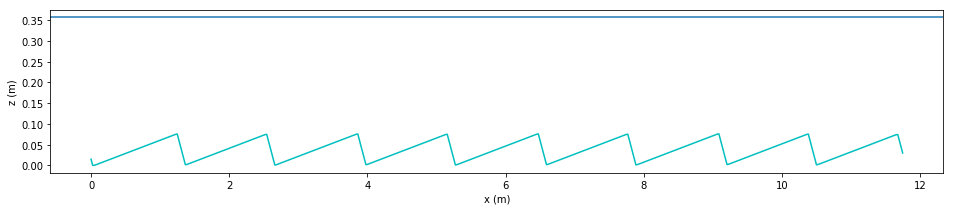

In [5]:
profile_folder = '/pymorph/notebooks/Paper_3/flume_profile_smoothed_v002.txt'
xc, z0 = mgl.readQueensFlume(profile_folder,1)

fig = plt.figure(figsize=(16, 3))
#plt.plot(xc,z0,'b')

dunes = 9

xsaw = np.linspace(0, 1,500)
simTime = 60*10 # Runtime in seconds
dt = 0.5 # Time step size (s)

zsaw = 0.076*(signal.sawtooth(2*dunes*np.pi * xsaw) + 1.)/2
xsaw = xsaw*xc.max()*dunes*0.5
#plt.plot(xsaw,zsaw)


dx = xsaw[1]-xsaw[0]
znew, iterations1 = schemes.avalanche_scheme.avalanche_model(dx,xsaw, zsaw, adjustment_angle=28.)
# Now flip it to run in reverse
zflip = np.flip(znew, axis=0)
zflip, iterations1 = schemes.avalanche_scheme.avalanche_model(dx,xsaw, zflip, adjustment_angle=28.)
znew = np.flip(zflip, axis=0)

znew = (znew - np.min(znew))/np.ptp(znew)
znew = znew*0.076

plt.plot(xsaw,znew,'-',color='c')
plt.axhline(0.357)
print(dx)
plt.xlabel('x (m)')
plt.ylabel('z (m)')

# Model Runs for Paper

- Equilibrium vs non-Equlibrium
- Shallow water vs simple flow model
- modified Ycr (+20%, -20%)
- other models (Euler, Upwinding, MacCormick)

In [6]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.002

#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 300*60       # Runtime in seconds
dt = 5                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*5

## 20 cm Case Non-Equilibrium

qin  0.07894736842105263
num_dim: 1
2019-05-18 00:17:37,059 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-18 00:17:55,979 INFO CLAW: Solution 1 computed for time t=300.000000
0.23698340269770887
0.4262016673398106


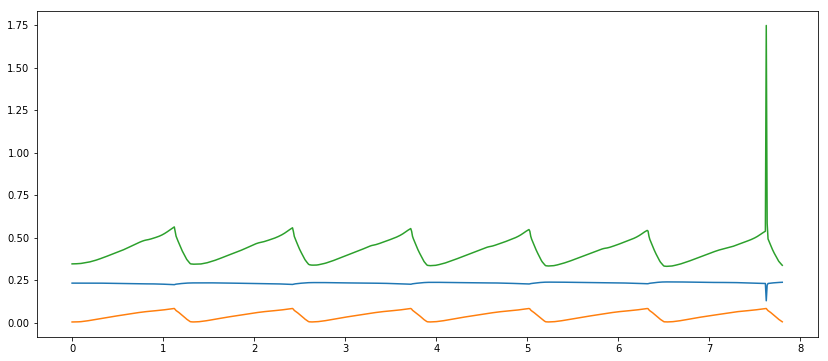

<Figure size 1008x432 with 0 Axes>

In [26]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut20, q20cm)
model.set_inital_conditions(sOut20, 0.0)
model.set_controller(tfinal = 300, num_output_times=1)
model.run()

h = model.get_hf()
surf = h + z0
u = model.get_uf()

fig = plt.figure(figsize=(14, 6))
plt.plot(x0, surf)
plt.plot(x0, z0)
plt.plot(x0, u)
fig = plt.figure(figsize=(14, 6))
print(surf[len(x0)-1])
print(model.get_uf().mean())



In [27]:
u

array([0.34533119, 0.34538642, 0.34544582, 0.34549839, 0.34578642,
       0.34608561, 0.34637485, 0.34665131, 0.3469118 , 0.3471526 ,
       0.34790002, 0.34877156, 0.3496129 , 0.3506339 , 0.35170467,
       0.3527306 , 0.35350312, 0.35411651, 0.35476533, 0.35578255,
       0.35710437, 0.35848804, 0.35987154, 0.36124687, 0.36267115,
       0.36416619, 0.36573948, 0.36735139, 0.36904253, 0.37085251,
       0.37269665, 0.37455171, 0.37637772, 0.37823276, 0.38012145,
       0.382061  , 0.38402607, 0.38601033, 0.38794422, 0.38992069,
       0.39193788, 0.39388288, 0.39587367, 0.39790743, 0.39993444,
       0.40196767, 0.40400999, 0.40595647, 0.40790277, 0.4098625 ,
       0.41182898, 0.41381138, 0.41581358, 0.41791155, 0.42005812,
       0.42223128, 0.42440404, 0.42658859, 0.42879652, 0.43111386,
       0.43350744, 0.43592154, 0.4383717 , 0.44085694, 0.44336473,
       0.44586007, 0.44833447, 0.45082392, 0.45332888, 0.45585104,
       0.4583902 , 0.46089406, 0.46329751, 0.46572053, 0.46812

 Starting simulation....
Number of time steps: 60.0 mins
Grid dx = 0.009762202753441801
Grid nx = 800
Initializing hydrodynamic model...
2019-05-16 01:01:21,583 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 01:01:57,278 INFO CLAW: Solution 1 computed for time t=300.000000
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max qbedload = 8.613785105079502e-06
2019-05-16 01:01:57,346 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 01:01:59,157 INFO CLAW: Solution 1 computed for time t=15.000000
2019-05-16 01:01:59,348 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 01:02:01,165 INFO CLAW: Solution 1 computed for time t=15.000000
2019-05-16 01:02:01,232 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 01:02:03,059 INFO CLAW: Solution 1 computed for time t=15.000000
2019-05-16 01:02:03,209 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 01:02:05,026 INFO CLAW: So

Text(0, 0.5, 'z (m)')

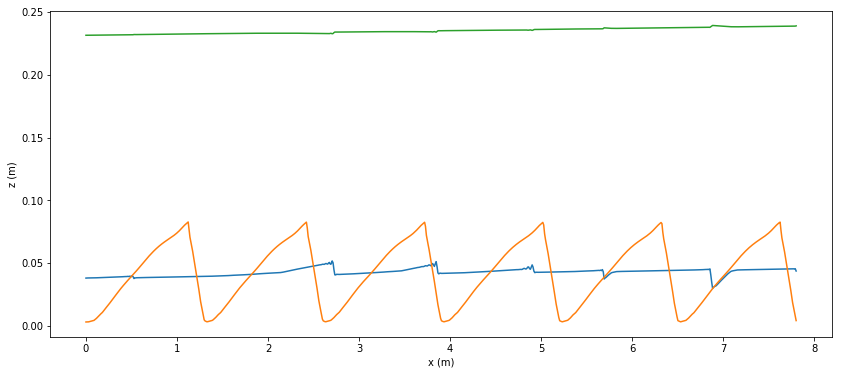

In [43]:


run_name = 'dune_5_q_{0}_h_{1}_D50_{2}'.format('20cm','237mm','1mm')

model = sdmodels.ShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q20cm, sOut20)
model.setup_chezy_hydro_model(ks, bed_slope)


#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h

df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

## 32 cm Flow Case 

2019-05-16 04:16:23,091 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-16 04:17:02,137 INFO CLAW: Solution 1 computed for time t=300.000000
0.3632198685789688
0.6292048652669885


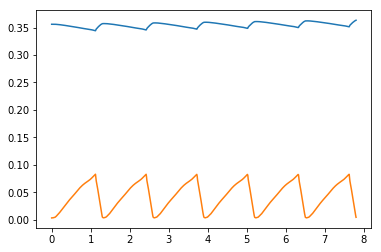

<Figure size 1008x432 with 0 Axes>

In [44]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut32, q32cm)
model.set_inital_conditions(sOut20, 0.0)
model.set_controller(tfinal = 300, num_output_times=1)
model.run()

h = model.get_hf()
surf = h + z0

plt.plot(x0, surf)
plt.plot(x0, z0)

fig = plt.figure(figsize=(14, 6))
print(surf[len(x0)-1])
print(model.get_uf().mean())

In [24]:
run_name = 'test_5_q_{0}_h_{1}_D50_{2}'.format('32m','357mm','1mm')

#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 360       # Runtime in seconds
dt = 30                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*1

model = sdmodels.ShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=30., rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)
model.configure_avalanche_model(30., 30., 30.)


#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h

df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)

verts = np.load(os.path.join('_output/{0}_verts.npy'))
fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

 Starting simulation....
Number of time steps: 0.2 mins
Grid dx = 0.009762202753441801
Grid nx = 800
Initializing hydrodynamic model...
qin  0.17960526315789474
num_dim: 1
2019-05-17 21:37:52,609 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-17 21:38:27,588 INFO CLAW: Solution 1 computed for time t=300.000000
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max qbedload = 9.114894508236018e-06
qin  0.17960526315789474
num_dim: 1
2019-05-17 21:38:27,653 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-17 21:38:29,402 INFO CLAW: Solution 1 computed for time t=15.000000
qin  0.17960526315789474
num_dim: 1
2019-05-17 21:38:30,606 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-17 21:38:32,330 INFO CLAW: Solution 1 computed for time t=15.000000
qin  0.17960526315789474
num_dim: 1
2019-05-17 21:38:32,395 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-17 21:38:34,131 INFO CLAW: Solution 1

FileNotFoundError: [Errno 2] No such file or directory: '_output/{0}_verts.npy'

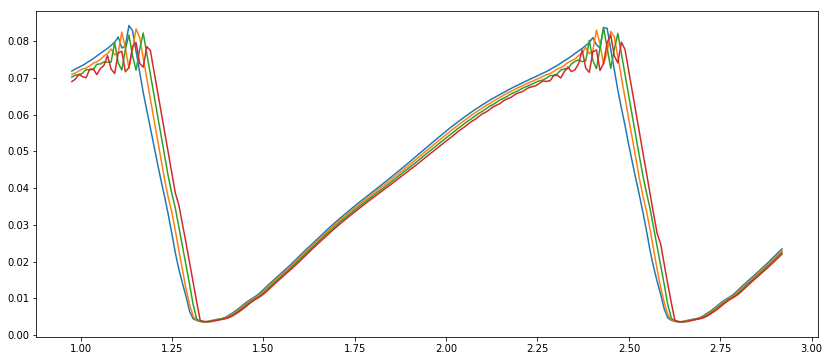

In [23]:
fig = plt.figure(figsize=(14, 6))

verts = np.load(os.path.join('_output/{0}_verts.npy').format(run_name, verts))
for t in range(0, (verts.shape[0])):
        z = verts[t,:,1]
        h = verts[t,:,4]
        x = verts[t,:,0]
        plt.plot(x[100:300],z[100:300])
        #ax3.plot(x,z+h, 'b')

In [16]:
verts


[[(0.0,
   0.001702292462663664,
   0.5165795884410702,
   0.17959165544198522,
   0.34765534577925444,
   1.0750284998835464e-06),
  (0.009762202753441801,
   0.0036791648831454474,
   0.519580863234331,
   0.17953502620525033,
   0.3455381806936951,
   1.1539725589294114e-06),
  (0.019524405506883603,
   0.003578841958509546,
   0.5192582314836237,
   0.1794898119552796,
   0.3456657999285666,
   1.1458713093404364e-06),
  (0.029286608260325406,
   0.0034626884154307118,
   0.5189209057734465,
   0.17944636945972542,
   0.3458067837761563,
   1.1373831066946465e-06),
  (0.039048811013767205,
   0.0036217146548901944,
   0.5190402579372212,
   0.1794039018043107,
   0.3456454466890503,
   1.1408989157796455e-06),
  (0.048811013767209005,
   0.0038058745934459464,
   0.5192063185940274,
   0.1793617798988897,
   0.3454537694852948,
   1.1456447954850408e-06),
  (0.05857321652065081,
   0.004005174139829973,
   0.5194008895779063,
   0.17931948294184785,
   0.3452429261096813,
   1.1511

In [29]:
xc.max()

7.8